In [13]:
# 导入必要的库
import sys
from pathlib import Path
import importlib.util
import numpy as np
import torch

# 设置路径
CURRENT_DIR = Path().resolve()  # 当前 notebook 目录
ROOT_DIR = CURRENT_DIR.parent  # MCUFlowNet 根目录
NASLIB_ROOT = ROOT_DIR / "NASLib"  # NASLib 路径
sys.path.insert(0, str(NASLIB_ROOT))  # 添加到路径

# 动态加载 TransNAS-Bench API
api_path = NASLIB_ROOT / "naslib" / "search_spaces" / "transbench101" / "api.py"
spec = importlib.util.spec_from_file_location("transbench_api", api_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)
TransNASBenchAPI = module.TransNASBenchAPI

# 动态加载 graph 模块（用于转换架构字符串）
graph_path = NASLIB_ROOT / "naslib" / "search_spaces" / "transbench101" / "graph.py"
spec = importlib.util.spec_from_file_location("transbench_graph", graph_path)
graph_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(graph_module)
Metric = graph_module.Metric

# 加载转换函数
from naslib.search_spaces.transbench101.conversions import (
    convert_op_indices_micro_to_str,
    convert_op_indices_macro_to_str,
)

# ========== 配置参数 ==========
SEARCH_SPACE = "micro"  # 选择 "micro" 或 "macro"
TASK = "segmentsemantic"  # 选择任务名称
TOP_BOTTOM = "bottom"  # 选择 "top" 或 "bottom"
TOP_K = 5  # 显示前 K 名
DATA_ROOT = NASLIB_ROOT / "naslib" / "data"  # 数据根目录

# ========== 加载 API ==========
pth_path = DATA_ROOT / "transnas-bench_v10141024.pth"  # 数据库文件路径
if not pth_path.exists():
    # 如果默认路径不存在，尝试其他路径
    pth_path = Path("transnas-bench_v10141024.pth")  # 当前目录
    assert pth_path.exists(), f"找不到数据库文件，请检查路径: {pth_path}"

api = TransNASBenchAPI(str(pth_path))  # 加载 API

# ========== 确定 GT 指标名称 ==========
# 根据任务类型选择对应的 GT 指标
if TASK in ["class_scene", "class_object", "jigsaw"]:
    metric_name = "valid_top1"  # 分类任务用准确率
elif TASK == "room_layout":
    metric_name = "valid_neg_loss"  # room_layout 用负损失
elif TASK == "segmentsemantic":
    metric_name = "valid_acc"  # 语义分割用准确率
else:  # autoencoder, normal
    metric_name = "valid_ssim"  # 重建任务用 SSIM

print(f"搜索空间: {SEARCH_SPACE}, 任务: {TASK}, GT 指标: {metric_name}")
print(f"开始遍历所有架构...\n")

# ========== 遍历所有架构并收集 GT 分数 ==========
arch_scores = []  # 存储 (架构字符串, GT分数) 的列表

# 获取该搜索空间的所有架构字符串
all_archs = api.all_arch_dict[SEARCH_SPACE]  # 所有架构字符串列表
print(f"总架构数: {len(all_archs)}")

# 遍历每个架构
for arch_str in all_archs:
    try:
        # 查询该架构在当前任务上的 GT 分数（使用 final 模式，即最后一轮的分数）
        gt_score = api.get_single_metric(arch_str, TASK, metric_name, mode="final")
        arch_scores.append((arch_str, gt_score))  # 保存架构和分数
    except Exception as e:
        # 如果查询失败（比如该架构在该任务上没有数据），跳过
        continue

print(f"成功查询到 {len(arch_scores)} 个架构的 GT 分数\n")

# ========== 按 GT 分数排序，找出前 K 名 ==========
# 按分数降序排序（分数越高越好）
arch_scores_sorted = sorted(arch_scores, key=lambda x: x[1], reverse=True)

# 取前 K 名
if TOP_BOTTOM == "top":
    top_k_archs = arch_scores_sorted[:TOP_K]
else:
    top_k_archs = arch_scores_sorted[-TOP_K:]

# ========== 显示结果 ==========
if TOP_BOTTOM == "top":
    print(f"========== {TASK} 任务 GT 前 {TOP_K} 名架构 ==========\n")
else:
    print(f"========== {TASK} 任务 GT 后 {TOP_K} 名架构 ==========\n")

for rank, (arch_str, gt_score) in enumerate(top_k_archs, 1):
    print(f"【第 {rank} 名】")
    print(f"  架构字符串: {arch_str}")
    print(f"  GT 分数 ({metric_name}): {gt_score:.6f}")
    
    # 尝试解析架构字符串为 op_indices（配置）
    try:
        # 对于 micro 空间，架构字符串格式类似 "64-41414-0_12_23_34_45_56"
        # 对于 macro 空间，格式不同
        if SEARCH_SPACE == "micro":
            # 从字符串中提取 op_indices（最后一部分，用下划线分隔）
            parts = arch_str.split("-")
            if len(parts) >= 3:
                op_indices_str = parts[-1]  # 例如 "0_12_23_34_45_56"
                op_indices = [int(x) for x in op_indices_str.split("_")]  # 转换为整数列表
                print(f"  架构配置 (op_indices): {op_indices}")
        else:
            # macro 空间的格式可能不同，这里先显示原始字符串
            print(f"  架构配置: {arch_str} (macro 格式)")
    except Exception as e:
        print(f"  架构配置: 解析失败 ({e})")
    
    print()  # 空行分隔

print("完成！")

搜索空间: micro, 任务: segmentsemantic, GT 指标: valid_acc
开始遍历所有架构...

总架构数: 4096
成功查询到 4096 个架构的 GT 分数

========== segmentsemantic 任务 GT 后 5 名架构 ==========

【第 1 名】
  架构字符串: 64-41414-2_22_022
  GT 分数 (valid_acc): 91.698540
  架构配置 (op_indices): [2, 22, 22]

【第 2 名】
  架构字符串: 64-41414-2_22_002
  GT 分数 (valid_acc): 91.676758
  架构配置 (op_indices): [2, 22, 2]

【第 3 名】
  架构字符串: 64-41414-2_02_002
  GT 分数 (valid_acc): 91.661171
  架构配置 (op_indices): [2, 2, 2]

【第 4 名】
  架构字符串: 64-41414-2_12_020
  GT 分数 (valid_acc): 91.644585
  架构配置 (op_indices): [2, 12, 20]

【第 5 名】
  架构字符串: 64-41414-2_02_022
  GT 分数 (valid_acc): 91.641205
  架构配置 (op_indices): [2, 2, 22]

完成！


分析架构: 64-41414-2_22_002
搜索空间: micro, 任务: segmentsemantic
使用 2 个 batch 计算梯度统计

解析后的 op_indices: [2, 2, 2, 0, 0, 2]
模型已创建

已准备 2 个 batch，每个 batch 大小: 8

已收集 37 层的梯度和特征图信息

已完成 37 层的统计分析

关键层数量: 9 / 37 (alpha=0)


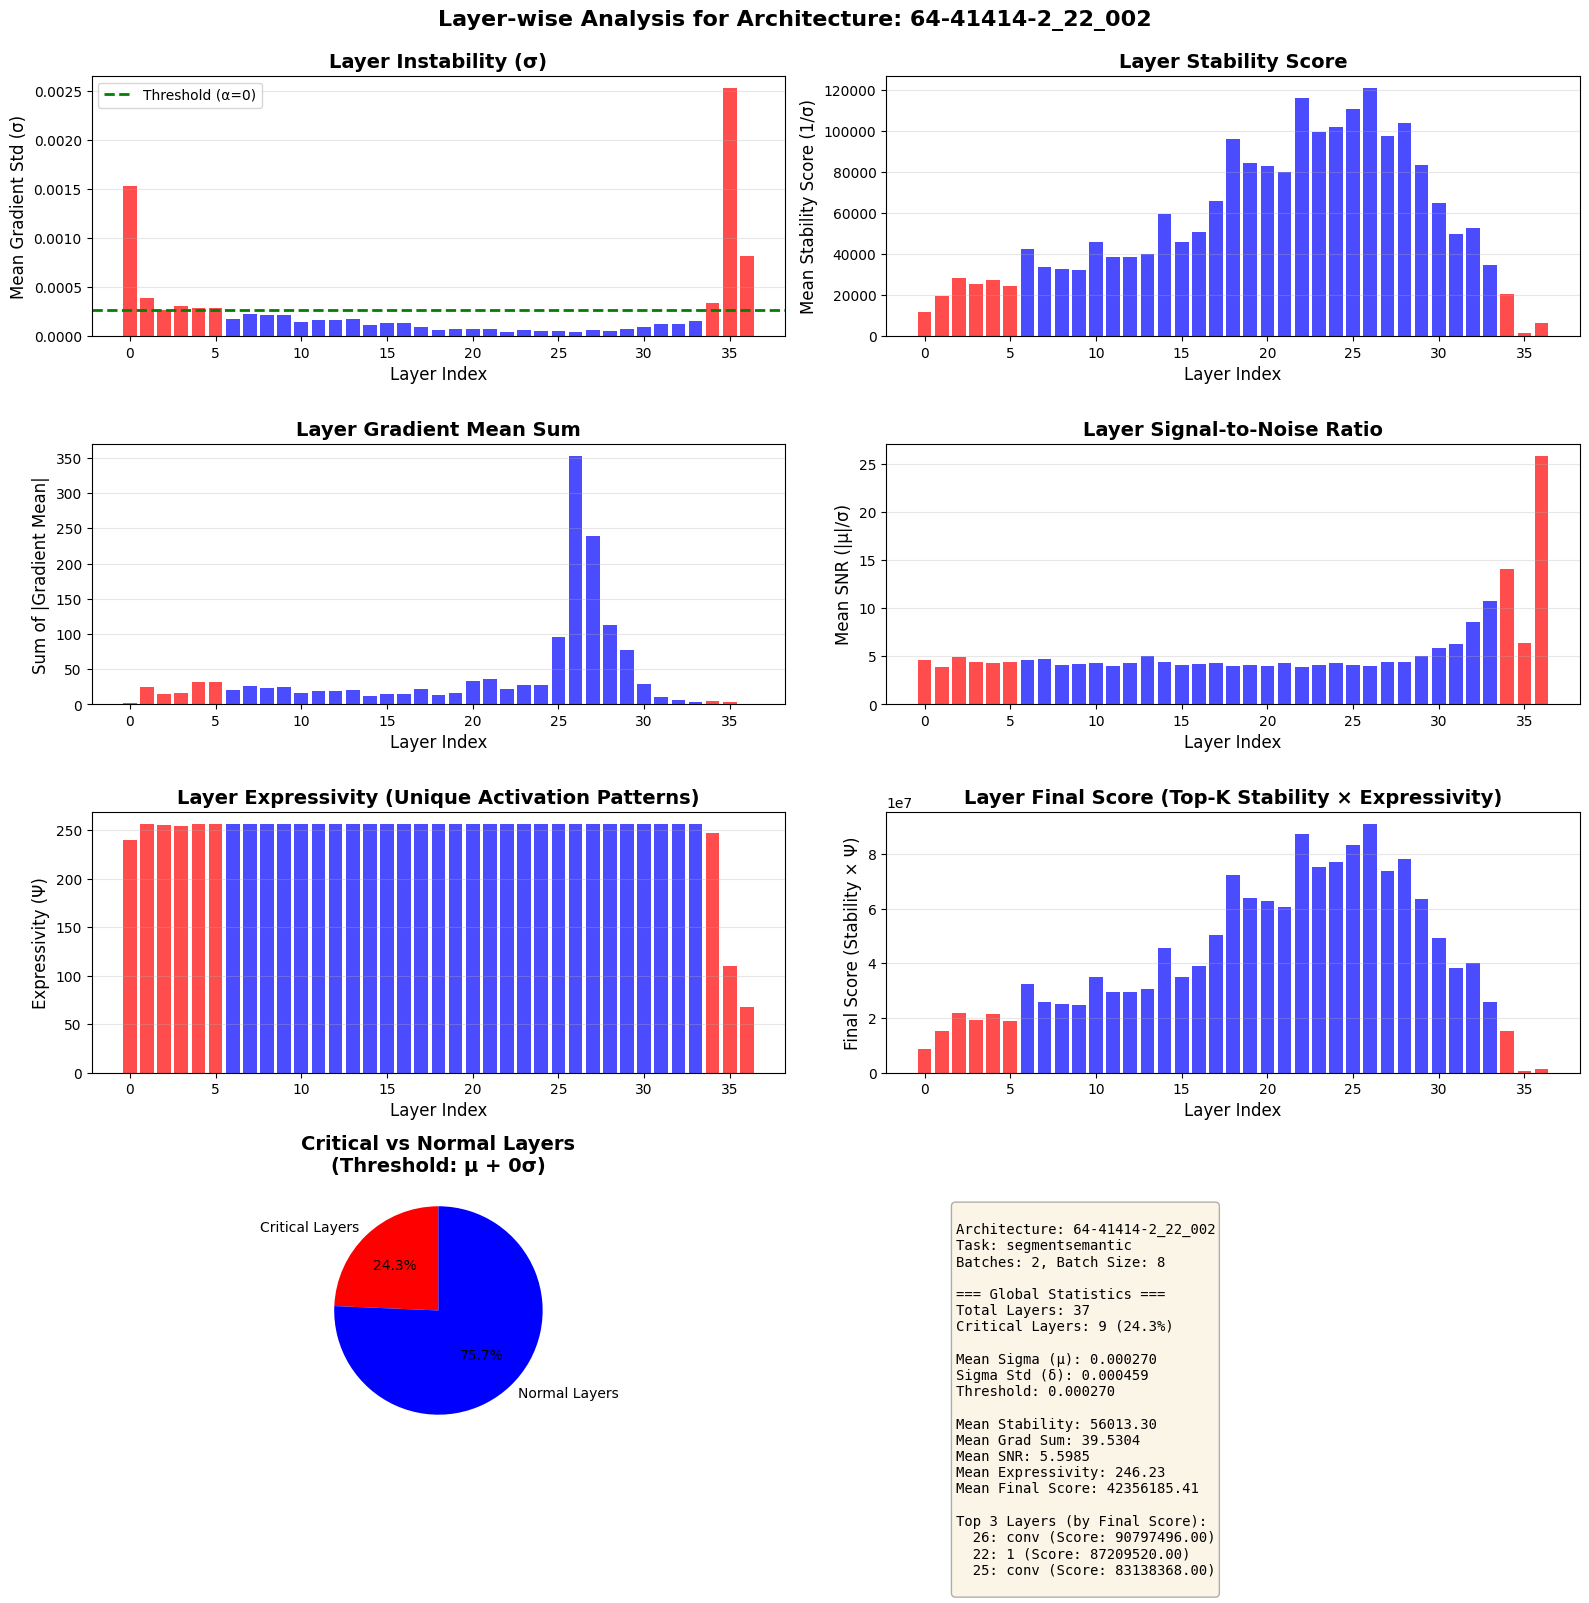


可视化完成！

分析完成！


In [17]:
# ========== 导入必要的库和定义辅助函数 ==========
import argparse
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
import importlib.util
import itertools
import matplotlib.pyplot as plt
import math


# 定义 load_transbench_classes 函数
def load_transbench_classes():
    """动态加载 transbench101 的搜索空间类"""
    graph_path = NASLIB_ROOT / "naslib" / "search_spaces" / "transbench101" / "graph.py"
    spec = importlib.util.spec_from_file_location("transbench_graph", graph_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.TransBench101SearchSpaceMicro, module.TransBench101SearchSpaceMacro, module

# ========== 配置参数 ==========
ARCH_STR = "64-41414-2_22_002"  # 架构字符串（从上一个 cell 的结果中复制）
SEARCH_SPACE = "micro"  # 搜索空间类型
TASK = "segmentsemantic"  # 任务名称： autoencoder，segmentsemantic，
BATCH_SIZE = 8  # batch 大小
NUM_BATCHES = 2  # 使用 2 个 batch 来计算梯度统计
TOP_K_PERCENT = 0.3  # Top-K 比例（计算表达能力时只看前 30% 的稳定通道）
ALPHA_THRESHOLD = 0  # 关键层筛选阈值
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # 计算设备
EPSILON = 1e-8  # 数值稳定项

print(f"分析架构: {ARCH_STR}")
print(f"搜索空间: {SEARCH_SPACE}, 任务: {TASK}")
print(f"使用 {NUM_BATCHES} 个 batch 计算梯度统计\n")

# ========== 从架构字符串创建模型 ==========
# 动态加载搜索空间类
TransBench101SearchSpaceMicro, TransBench101SearchSpaceMacro, graph_module = load_transbench_classes()
Metric = graph_module.Metric

# 根据搜索空间类型创建搜索空间对象
if SEARCH_SPACE == "micro":
    if TASK == "segmentsemantic":
        ss = TransBench101SearchSpaceMicro(dataset=TASK, create_graph=True, n_classes=17)
    else:
        ss = TransBench101SearchSpaceMicro(dataset=TASK, create_graph=True)
else:
    ss = TransBench101SearchSpaceMacro(dataset=TASK, create_graph=True)

# ========== 解析架构字符串为 op_indices ==========
if SEARCH_SPACE == "micro":
    # micro 格式: "64-41414-X_YY_YYY"
    parts = ARCH_STR.split("-")
    config_part = parts[-1]  # 例如 "3_33_213"
    config_parts = config_part.split("_")  # ["3", "33", "213"]
    
    # 解析为 6 个 op_indices
    op_indices = []
    op_indices.append(int(config_parts[0]))  # 第 1 个：X
    for digit in config_parts[1]:  # 第 2-3 个：YY
        op_indices.append(int(digit))
    for digit in config_parts[2]:  # 第 4-6 个：YYY
        op_indices.append(int(digit))
    
    print(f"解析后的 op_indices: {op_indices}")
else:
    # macro 格式: "64-XXXXXX-basic"
    parts = ARCH_STR.split("-")
    ops_string = parts[1]
    op_indices = [int(d) for d in ops_string]
    while len(op_indices) < 6:
        op_indices.append(0)
    print(f"解析后的 op_indices: {op_indices}")

# 设置架构配置
ss.set_op_indices(op_indices)
ss.parse()
model = ss.to(DEVICE)
model.train()

print(f"模型已创建\n")

# ========== 准备数据加载器 ==========
data_root = NASLIB_ROOT / "naslib" / "data"
from naslib import utils
get_train_val_loaders = utils.get_train_val_loaders

search_cfg = argparse.Namespace(
    seed=42,
    batch_size=BATCH_SIZE,
    train_portion=0.7,
)
config = argparse.Namespace(
    data=str(data_root),
    dataset=TASK,
    search=search_cfg,
)

train_loader, _, _, _, _ = get_train_val_loaders(config)
train_batches = list(itertools.islice(iter(train_loader), NUM_BATCHES))

print(f"已准备 {len(train_batches)} 个 batch，每个 batch 大小: {BATCH_SIZE}\n")

# ========== 准备损失函数 ==========
if TASK in ["autoencoder", "normal"]:
    loss_fn = torch.nn.L1Loss()
elif TASK == "segmentsemantic":
    loss_fn = torch.nn.CrossEntropyLoss()
else:
    loss_fn = torch.nn.CrossEntropyLoss()

loss_fn = loss_fn.to(DEVICE)

# ========== 收集梯度信息和特征图 ==========
raw_grads = {}  # 存放每层的梯度列表 {层名: [Tensor(P), ...]}
batch_features = {}  # 存放每层的特征图列表 {层名: [Tensor(B, C, H, W), ...]}

# 注册 Forward Hook 用于捕获特征图
features_dict = {}

def get_feature_hook(name):
    """返回一个带有下采样逻辑的 Hook 函数，先压缩再存特征图。"""
    def hook(module, inputs_hook, output_hook):
        out = output_hook.detach()  # 先 detach，切断计算图
        # 如果是卷积特征图 (B, C, H, W) 且空间尺寸大于 16x16，则做自适应平均池化
        if out.dim() == 4 and (out.shape[2] > 16 or out.shape[3] > 16):
            out = torch.nn.functional.adaptive_avg_pool2d(out, (16, 16))  # 下采样到 16x16
        features_dict[name] = out
    return hook

hooks = []
for name, mod in model.named_modules():
    if isinstance(mod, (nn.Conv2d, nn.Linear)):
        hooks.append(mod.register_forward_hook(get_feature_hook(name)))

# 遍历每个 batch
for batch_idx, (data, label) in enumerate(train_batches):
    model.zero_grad()
    data = data.to(DEVICE)
    label = label.to(DEVICE)
    
    # 【关键修复】：对于 segmentsemantic 任务，标签需要转换为 Long 类型
    if TASK == "segmentsemantic":
        label = label.long()
    
    # 前向传播
    logits = model(data)
    loss = loss_fn(logits, label)
    
    # 反向传播
    loss.backward()
    
    # 收集梯度
    for name, mod in model.named_modules():
        if isinstance(mod, (torch.nn.Conv2d, torch.nn.Linear)) and mod.weight.grad is not None:
            g = mod.weight.grad.detach().reshape(-1)
            if name not in raw_grads:
                raw_grads[name] = []
            raw_grads[name].append(g.cpu())
    
    # 收集特征图
    for name, mod in model.named_modules():
        if isinstance(mod, (nn.Conv2d, nn.Linear)) and name in features_dict:
            fmap = features_dict[name]
            if name not in batch_features:
                batch_features[name] = []
            batch_features[name].append(fmap.cpu())

# 移除 Hooks
for h in hooks:
    h.remove()

print(f"已收集 {len(raw_grads)} 层的梯度和特征图信息\n")

# ========== 计算梯度统计信息和表达能力 ==========
layer_stats = {}

for name, grads_list in raw_grads.items():
    # Stack 梯度 -> (Num_Batches, P)
    grads = torch.stack(grads_list)
    
    # 计算梯度均值（沿 batch 维度）
    grad_mean = torch.mean(grads, dim=0)  # shape: (P,)
    
    # 计算梯度标准差（沿 batch 维度）
    grad_std = torch.std(grads, dim=0)  # shape: (P,)
    
    # 稳定性分数 S_w = 1 / Sigma_w
    s_w = 1.0 / (grad_std + EPSILON)
    
    # 层级混乱度（平均标准差）
    mean_sigma_l = torch.mean(grad_std).item()
    
    # 层级稳定性（平均稳定性分数）
    mean_stability_l = torch.mean(s_w).item()
    
    # 【新增】计算梯度均值的和（绝对值）
    grad_mean_sum = torch.sum(torch.abs(grad_mean)).item()
    
    # 【新增】计算信噪比（SNR = |mean| / std）
    snr = torch.abs(grad_mean) / (grad_std + EPSILON)  # 每个参数的信噪比
    mean_snr_l = torch.mean(snr).item()  # 层级平均信噪比
    
    # ========== 计算表达能力（Psi）==========
    psi_l = 1.0  # 默认表达能力
    
    if name in batch_features:
        # 获取 weight shape 来确定通道数
        module = dict(model.named_modules())[name]
        weight_shape = module.weight.shape
        out_channels = weight_shape[0]
        num_params = s_w.numel()
        params_per_channel = num_params // out_channels
        
        # 计算 Top-K 稳定参数对应的通道
        k_count = max(1, int(num_params * TOP_K_PERCENT))
        sorted_s, sorted_indices = torch.sort(s_w, descending=True)
        top_k_indices = sorted_indices[:k_count]
        
        # 将参数索引转换为通道索引
        top_k_channel_indices = torch.unique(top_k_indices // params_per_channel)
        
        # 计算这些 Top-K 通道的表达能力
        psi_sum = 0.0
        valid_batches = 0
        
        for fmap in batch_features[name]:
            fmap = fmap.to(DEVICE)  # (B, C, H, W) 或 (B, C)
            
            # 只选出 Top-K Channels
            selected_fmap = torch.index_select(fmap, 1, top_k_channel_indices.to(DEVICE))
            
            # 二值化
            bin_map = (selected_fmap > 0).float()
            
            # 展平计算唯一编码
            B = bin_map.size(0)
            flat_codes = bin_map.view(B, -1)
            neuron_codes = flat_codes.t()  # 转置，每行代表一个神经元
            unique_codes = torch.unique(neuron_codes, dim=0)
            psi_sum += float(unique_codes.size(0))
            valid_batches += 1
        
        if valid_batches > 0:
            psi_l = psi_sum / valid_batches
    
    # 计算最终层得分
    top_k_s_mean = torch.mean(sorted_s[:k_count]).item() if k_count > 0 else mean_stability_l
    final_score_l = top_k_s_mean * psi_l
    
    # 保存统计信息
    layer_stats[name] = {
        'num_params': num_params,
        'mean_sigma': mean_sigma_l,  # 层级平均标准差（混乱度）
        'mean_stability': mean_stability_l,  # 层级平均稳定性
        'grad_mean_sum': grad_mean_sum,  # 【新增】梯度均值的和
        'mean_snr': mean_snr_l,  # 【新增】层级平均信噪比
        'psi': psi_l,  # 表达能力
        'final_score': final_score_l,  # 最终得分（稳定性 × 表达能力）
        'top_k_stability': top_k_s_mean,  # Top-K 平均稳定性
    }

print(f"已完成 {len(layer_stats)} 层的统计分析\n")

# ========== 计算关键层 ==========
mean_sigmas = [stats['mean_sigma'] for stats in layer_stats.values()]
mu_global = np.mean(mean_sigmas)
delta_global = np.std(mean_sigmas)
threshold = mu_global + ALPHA_THRESHOLD * delta_global

critical_layers = [
    name for name, stats in layer_stats.items() if stats['mean_sigma'] > threshold
]

print(f"关键层数量: {len(critical_layers)} / {len(layer_stats)} (alpha={ALPHA_THRESHOLD})")

# ========== 可视化 ==========
fig = plt.figure(figsize=(16, 16))  # 增加高度以容纳 4x2 布局

# 准备数据
layer_names = list(layer_stats.keys())
layer_names_short = [name.split('.')[-1] if '.' in name else name for name in layer_names]  # 缩短层名
sigmas = [layer_stats[name]['mean_sigma'] for name in layer_names]
stabilities = [layer_stats[name]['mean_stability'] for name in layer_names]
grad_mean_sums = [layer_stats[name]['grad_mean_sum'] for name in layer_names]  # 【新增】
mean_snrs = [layer_stats[name]['mean_snr'] for name in layer_names]  # 【新增】
psis = [layer_stats[name]['psi'] for name in layer_names]
final_scores = [layer_stats[name]['final_score'] for name in layer_names]
is_critical = [name in critical_layers for name in layer_names]

# 颜色：关键层用红色，普通层用蓝色
colors = ['red' if crit else 'blue' for crit in is_critical]

# 子图1：每层的混乱度（Sigma）
ax1 = plt.subplot(4, 2, 1)
bars1 = ax1.bar(range(len(layer_names)), sigmas, color=colors, alpha=0.7)
ax1.axhline(y=threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold (α={ALPHA_THRESHOLD})')
ax1.set_xlabel('Layer Index', fontsize=12)
ax1.set_ylabel('Mean Gradient Std (σ)', fontsize=12)
ax1.set_title('Layer Instability (σ)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 子图2：每层的稳定性分数（1/Sigma）
ax2 = plt.subplot(4, 2, 2)
bars2 = ax2.bar(range(len(layer_names)), stabilities, color=colors, alpha=0.7)
ax2.set_xlabel('Layer Index', fontsize=12)
ax2.set_ylabel('Mean Stability Score (1/σ)', fontsize=12)
ax2.set_title('Layer Stability Score', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 【新增】子图3：每层梯度均值的和
ax3 = plt.subplot(4, 2, 3)
bars3 = ax3.bar(range(len(layer_names)), grad_mean_sums, color=colors, alpha=0.7)
ax3.set_xlabel('Layer Index', fontsize=12)
ax3.set_ylabel('Sum of |Gradient Mean|', fontsize=12)
ax3.set_title('Layer Gradient Mean Sum', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 【新增】子图4：每层的信噪比
ax4 = plt.subplot(4, 2, 4)
bars4 = ax4.bar(range(len(layer_names)), mean_snrs, color=colors, alpha=0.7)
ax4.set_xlabel('Layer Index', fontsize=12)
ax4.set_ylabel('Mean SNR (|μ|/σ)', fontsize=12)
ax4.set_title('Layer Signal-to-Noise Ratio', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 子图5：每层的表达能力（Psi）
ax5 = plt.subplot(4, 2, 5)
bars5 = ax5.bar(range(len(layer_names)), psis, color=colors, alpha=0.7)
ax5.set_xlabel('Layer Index', fontsize=12)
ax5.set_ylabel('Expressivity (Ψ)', fontsize=12)
ax5.set_title('Layer Expressivity (Unique Activation Patterns)', fontsize=14, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 子图6：最终得分（稳定性 × 表达能力）
ax6 = plt.subplot(4, 2, 6)
bars6 = ax6.bar(range(len(layer_names)), final_scores, color=colors, alpha=0.7)
ax6.set_xlabel('Layer Index', fontsize=12)
ax6.set_ylabel('Final Score (Stability × Ψ)', fontsize=12)
ax6.set_title('Layer Final Score (Top-K Stability × Expressivity)', fontsize=14, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

# 子图7：关键层分布（饼图）
ax7 = plt.subplot(4, 2, 7)
critical_count = len(critical_layers)
normal_count = len(layer_names) - critical_count
ax7.pie([critical_count, normal_count], 
        labels=['Critical Layers', 'Normal Layers'],
        colors=['red', 'blue'],
        autopct='%1.1f%%',
        startangle=90)
ax7.set_title(f'Critical vs Normal Layers\n(Threshold: μ + {ALPHA_THRESHOLD}σ)', fontsize=14, fontweight='bold')

# 子图8：汇总统计（文本）
ax8 = plt.subplot(4, 2, 8)
ax8.axis('off')
summary_text = f"""
Architecture: {ARCH_STR}
Task: {TASK}
Batches: {NUM_BATCHES}, Batch Size: {BATCH_SIZE}

=== Global Statistics ===
Total Layers: {len(layer_stats)}
Critical Layers: {critical_count} ({100*critical_count/len(layer_stats):.1f}%)

Mean Sigma (μ): {mu_global:.6f}
Sigma Std (δ): {delta_global:.6f}
Threshold: {threshold:.6f}

Mean Stability: {np.mean(stabilities):.2f}
Mean Grad Sum: {np.mean(grad_mean_sums):.4f}
Mean SNR: {np.mean(mean_snrs):.4f}
Mean Expressivity: {np.mean(psis):.2f}
Mean Final Score: {np.mean(final_scores):.2f}

Top 3 Layers (by Final Score):
"""
# 找出得分最高的3层
top_3_indices = np.argsort(final_scores)[-3:][::-1]
for idx in top_3_indices:
    summary_text += f"  {idx}: {layer_names_short[idx]} (Score: {final_scores[idx]:.2f})\n"

ax8.text(0.1, 0.9, summary_text, transform=ax8.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle(f'Layer-wise Analysis for Architecture: {ARCH_STR}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n可视化完成！")

# 清理显存
model.cpu()
del model
torch.cuda.empty_cache()

print("\n分析完成！")